# Semantic Image Segmentation

Oxford-IIIT Pet dataset

M. Hawryluk, AGH 2023


## Import modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.utils as utils
import cv2
from random import shuffle, seed

## Data preprocessing

In [ ]:
oxford_ds, oxford_info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteAQENKK/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteAQENKK/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
oxford_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmp8d65r8sjtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [ ]:
next(iter(oxford_ds["train"]))['image'].shape

TensorShape([500, 500, 3])

In [ ]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

def resize(image):
   return tf.image.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), method="nearest")

In [ ]:
def preprocess_data(data):
   image = data["image"]
   mask = data["segmentation_mask"]

   image = resize(image)
   mask = resize(mask)

   image = tf.cast(image, tf.float32) / 255.0
   mask -= 1

   return image, mask

In [ ]:
ds_train = oxford_ds["train"].map(preprocess_data)
ds_test = oxford_ds["test"].map(preprocess_data)

In [ ]:
next(iter(ds_train))[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01960784, 0.01176471, 0.01568628],
        [0.02352941, 0.01568628, 0.01960784],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.01176471, 0.00392157, 0.00784314],
        [0.00392157, 0.00392157, 0.        ],
        [0.02745098, 0.01176471, 0.01568628]],

       [[0.01176471, 0.01176471, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.01960784, 0.01176471, 0.01568628],
        ...,
        [0.00392157, 0.        , 0.        ],
        [0.00784314, 0.00784314, 0.        ],
        [0.01568628, 0.01568628, 0.01568628]],

       [[0.01176471, 0.01960784, 0.01568628],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01568628, 0.02352941, 0.01960784],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.01960784, 0.01176471, 0.01568628],
        [0.01960784, 0.01176471, 0.02352941]],

       ...,

       [[0.02745098, 0.02745098, 0.03529412],
        [0.01

In [ ]:
example_mask = next(iter(ds_train))[1].numpy()
np.unique(example_mask)

array([0, 1, 2], dtype=uint8)

In [ ]:
batch_size = 32

ds_train_batched = ds_train.cache().batch(batch_size).repeat()
ds_val_batched = ds_test.take(3000).batch(batch_size)
ds_test_batched = ds_test.skip(3000).batch(batch_size)

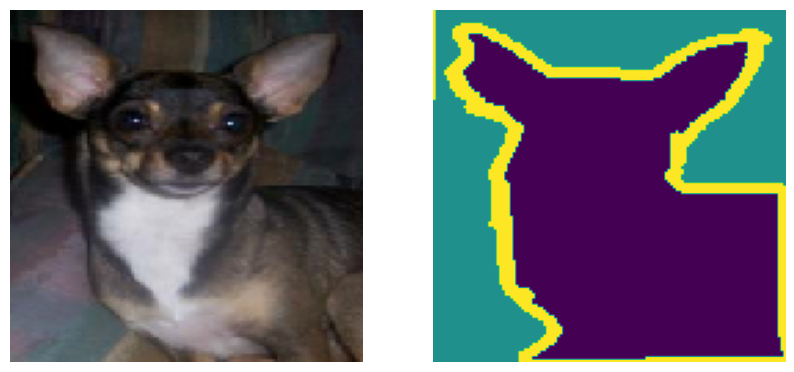

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

x, y = next(iter(ds_train.skip(13)))

ax[0].axis('off')
ax[1].axis('off')

ax[0].imshow(x)
ax[1].imshow(y)

plt.show()

In [ ]:
def get_mask(prediction):
 mask = tf.argmax(prediction, axis=-1)
 mask = mask[..., tf.newaxis]
 return mask[0]

## Neural segmentation model
### Unet

In [ ]:
def encoding_block(x, num_filters, dropout_rate=0.2, kernel_size=3):
  a = layers.Conv2D(num_filters, kernel_size, padding="same", activation="relu")(x)
  b = layers.MaxPool2D(2)(a)
  b = layers.Dropout(dropout_rate)(b)
  return a, b

def decoding_block(x, s, num_filters, dropout_rate=0.2, kernel_size=3):
  x = layers.Conv2DTranspose(num_filters, kernel_size, 2, padding="same")(x)
  x = layers.concatenate([x, s])
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Conv2D(num_filters, kernel_size, padding="same", activation="relu")(x)
  return x

def unet(num_classes=3):
  inputs = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

  # encoder
  s1, e1 = encoding_block(inputs, 64)
  s2, e2 = encoding_block(e1, 128)
  s3, e3 = encoding_block(e2, 256)
  s4, e4 = encoding_block(e3, 512)
  b = layers.Conv2D(1024, 3, padding="same", activation="relu")(e4)

  # decoder
  d1 = decoding_block(b, s4, 512)
  d2 = decoding_block(d1, s3, 256)
  d3 = decoding_block(d2, s2, 128)
  d4 = decoding_block(d3, s1, 64)
  outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

  return keras.Model(inputs, outputs)

In [ ]:
model = unet()
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [ ]:
# !unzip model.zip
# model = keras.models.load_model('pets-1')

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 128, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_8[0][0]']            
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 64, 64, 64)           0         ['max_pooling2d[0][0]'] 

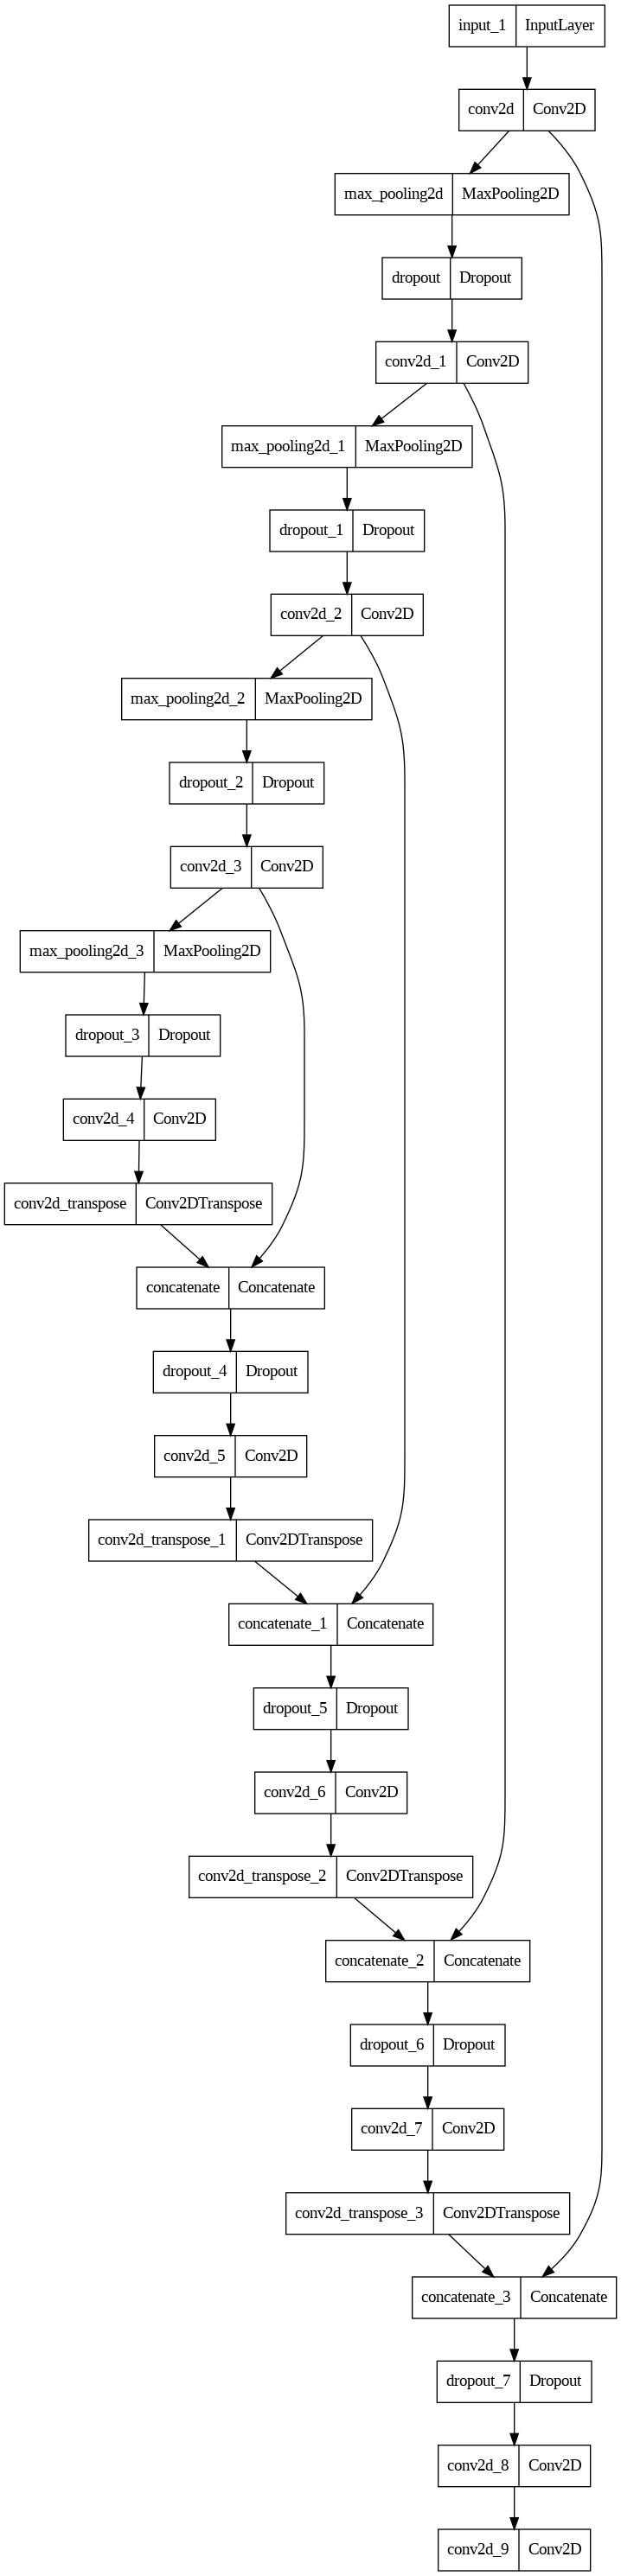

In [ ]:
utils.plot_model(model)

In [ ]:
epochs = 20

model_history = model.fit(
    ds_train_batched,
    epochs=epochs,
    steps_per_epoch=oxford_info.splits["train"].num_examples // batch_size,
    validation_steps=oxford_info.splits["test"].num_examples // batch_size // 5,
    validation_data=ds_val_batched
)

Epoch 1/20
57/57 [==============================] - 77s 701ms/step - loss: 0.8993 - accuracy: 0.5966 - val_loss: 0.7810 - val_accuracy: 0.6929
Epoch 2/20
57/57 [==============================] - 58s 718ms/step - loss: 0.7413 - accuracy: 0.6935 - val_loss: 0.6851 - val_accuracy: 0.7248
Epoch 3/20
57/57 [==============================] - 40s 701ms/step - loss: 0.6397 - accuracy: 0.7444 - val_loss: 0.6233 - val_accuracy: 0.7544
Epoch 4/20
57/57 [==============================] - 40s 704ms/step - loss: 0.5868 - accuracy: 0.7675 - val_loss: 0.6476 - val_accuracy: 0.7367
Epoch 5/20
57/57 [==============================] - 40s 706ms/step - loss: 0.5370 - accuracy: 0.7879 - val_loss: 0.5309 - val_accuracy: 0.7908
Epoch 6/20
57/57 [==============================] - 40s 708ms/step - loss: 0.4966 - accuracy: 0.8053 - val_loss: 0.4857 - val_accuracy: 0.8149
Epoch 7/20
57/57 [==============================] - 40s 708ms/step - loss: 0.4660 - accuracy: 0.8181 - val_loss: 0.4640 - val_accuracy: 0.8196

In [ ]:
model.save('pets-1')
!zip model.zip pets-1/*

  adding: pets-1/assets/ (stored 0%)
  adding: pets-1/fingerprint.pb (stored 0%)
  adding: pets-1/keras_metadata.pb (deflated 94%)
  adding: pets-1/saved_model.pb (deflated 90%)
  adding: pets-1/variables/ (stored 0%)


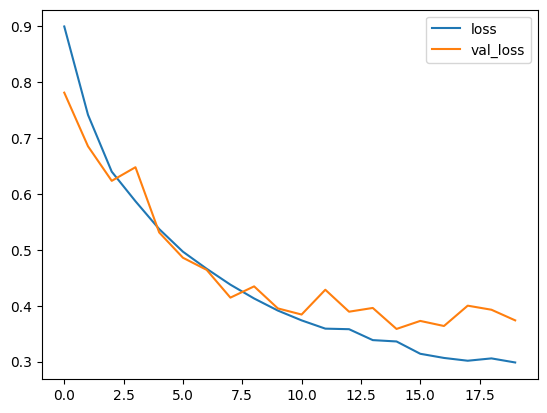

In [ ]:
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
predicted = model.predict(ds_test_batched)

11/11 [==============================] - 18s 879ms/step


1/1 [==============================] - 0s 20ms/step


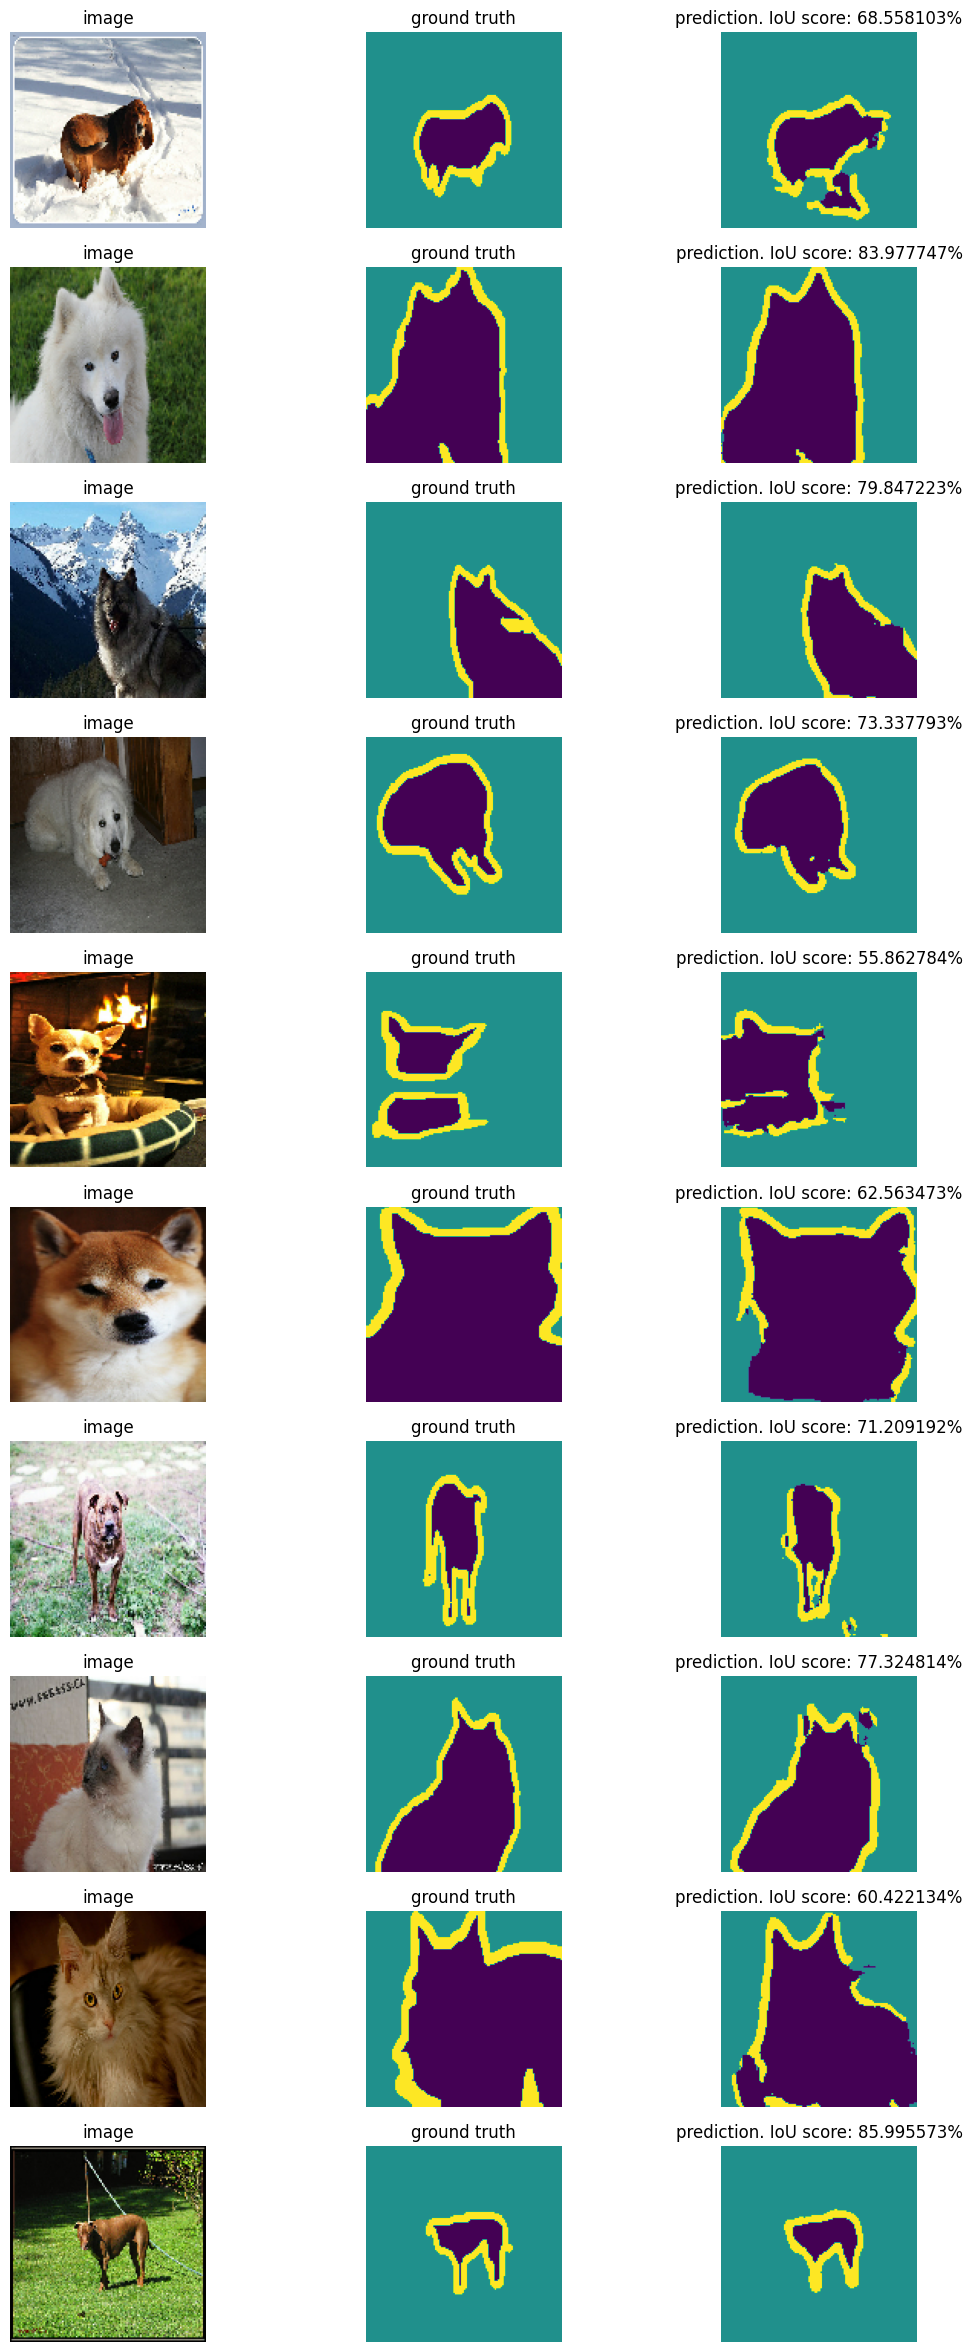

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(13, 30))

for i, (x, y) in enumerate(ds_test.skip(10).take(10)):
  y_pred = get_mask(model.predict(tf.expand_dims(x, axis=0)))
  score = keras.metrics.IoU(3, target_class_ids=list(range(3)))(y_pred, y)

  ax[i][0].axis('off')
  ax[i][1].axis('off')
  ax[i][2].axis('off')

  ax[i][0].set_title('image')
  ax[i][1].set_title('ground truth')
  ax[i][2].set_title(f'prediction. IoU score: {score:%}')

  ax[i][0].imshow(x)
  ax[i][1].imshow(y)
  ax[i][2].imshow(y_pred)

plt.show()

## Hyperparameter space search

In [ ]:
!pip install keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
def model_builder(hp):
  hp_dropout_rate = hp.Float('dropout rate', min_value=0.1, max_value=0.8, step=0.1)
  hp_kernel_size = hp.Int('kernel size', min_value=3, max_value=7, step=2)

  inputs = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

  # encoder
  s1, e1 = encoding_block(inputs, 64, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  s2, e2 = encoding_block(e1, 128, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  s3, e3 = encoding_block(e2, 256, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  s4, e4 = encoding_block(e3, 512, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  b = layers.Conv2D(1024, 3, padding="same", activation="relu")(e4)

  # decoder
  d1 = decoding_block(b, s4, 512, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  d2 = decoding_block(d1, s3, 256, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  d3 = decoding_block(d2, s2, 128, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  d4 = decoding_block(d3, s1, 64, dropout_rate=hp_dropout_rate, kernel_size=hp_kernel_size)
  outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(d4)

  model = keras.Model(inputs, outputs)

  model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy",
  )

  return model

In [ ]:
tuner = kt.Hyperband(
        model_builder,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='hyperband'
      )

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(
    ds_train_batched,
    epochs=10,
    steps_per_epoch=oxford_info.splits["train"].num_examples // batch_size,
    validation_steps=oxford_info.splits["test"].num_examples // batch_size // 5,
    validation_data=ds_val_batched,
    callbacks=[stop_early],
)

Trial 24 Complete [00h 00m 12s]

Best val_accuracy So Far: 0.860060453414917
Total elapsed time: 01h 34m 21s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
0.4               |0.3               |dropout rate
5                 |3                 |kernel size
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/10


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/eng

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node model/conv2d_transpose_2/conv2d_transpose defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-65-f2053c1b2e90>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 233, in search

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/conv2d_transpose.py", line 296, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 6268, in conv2d_transpose

OOM when allocating tensor with shape[32,128,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_transpose_2/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_245765]


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('best droput rate:', best_hps.get('dropout rate'))
print('best kernel size:', best_hps.get('kernel size'))

In [ ]:
!zip hyperband.zip hyperband/*/*

  adding: hyperband/untitled_project/oracle.json (deflated 67%)
  adding: hyperband/untitled_project/trial_0000/ (stored 0%)
  adding: hyperband/untitled_project/trial_0001/ (stored 0%)
  adding: hyperband/untitled_project/trial_0002/ (stored 0%)
  adding: hyperband/untitled_project/trial_0003/ (stored 0%)
  adding: hyperband/untitled_project/trial_0004/ (stored 0%)
  adding: hyperband/untitled_project/trial_0005/ (stored 0%)
  adding: hyperband/untitled_project/trial_0006/ (stored 0%)
  adding: hyperband/untitled_project/trial_0007/ (stored 0%)
  adding: hyperband/untitled_project/trial_0008/ (stored 0%)
  adding: hyperband/untitled_project/trial_0009/ (stored 0%)
  adding: hyperband/untitled_project/trial_0010/ (stored 0%)
  adding: hyperband/untitled_project/trial_0011/ (stored 0%)
  adding: hyperband/untitled_project/trial_0012/ (stored 0%)
  adding: hyperband/untitled_project/trial_0013/ (stored 0%)
  adding: hyperband/untitled_project/trial_0014/ (stored 0%)
  adding: hyperband/u

## Transfer learning

### VGG16

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = base_model(inputs, training=False)

size = 4
while size < IMAGE_WIDTH:
  x = layers.Conv2DTranspose(16, 3, 2, padding="same")(x)
  x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
  size *= 2

x = layers.Dense(3)(x)
transfer_model = keras.Model(inputs, x)

In [ ]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [ ]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 16)          73744     
 Transpose)                                                      
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          2320      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 16)        2320      
 Transpose)                                                      
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        2320

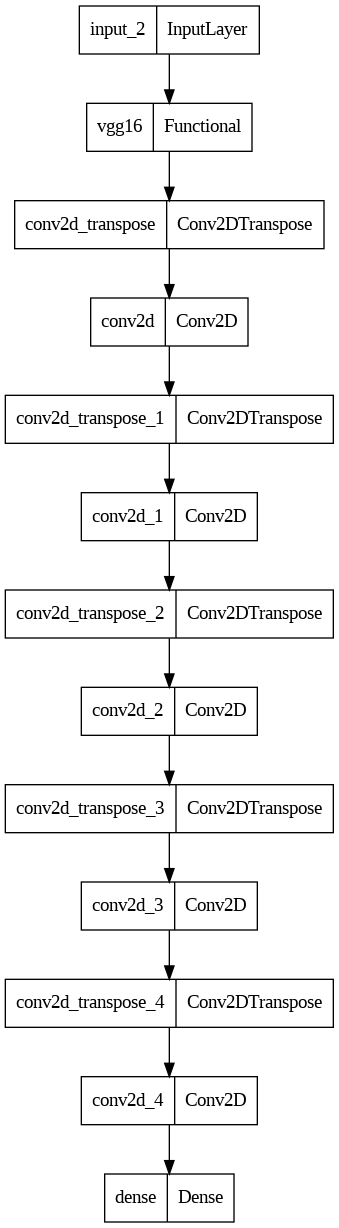

In [ ]:
utils.plot_model(transfer_model)

In [ ]:
epochs = 20

transfer_model_history = transfer_model.fit(
    ds_train_batched,
    epochs=epochs,
    steps_per_epoch=oxford_info.splits["train"].num_examples // batch_size,
    validation_steps=oxford_info.splits["test"].num_examples // batch_size // 5,
    validation_data=ds_val_batched
)

Epoch 1/20
115/115 [==============================] - 12s 82ms/step - loss: 1.0236 - accuracy: 0.5821 - val_loss: 0.9418 - val_accuracy: 0.5733
Epoch 2/20
115/115 [==============================] - 9s 78ms/step - loss: 0.9216 - accuracy: 0.5866 - val_loss: 0.9400 - val_accuracy: 0.5733
Epoch 3/20
115/115 [==============================] - 9s 77ms/step - loss: 0.9012 - accuracy: 0.5928 - val_loss: 0.7870 - val_accuracy: 0.6477
Epoch 4/20
115/115 [==============================] - 10s 84ms/step - loss: 0.6593 - accuracy: 0.7538 - val_loss: 0.6159 - val_accuracy: 0.7787
Epoch 5/20
115/115 [==============================] - 10s 88ms/step - loss: 0.5907 - accuracy: 0.7862 - val_loss: 0.5865 - val_accuracy: 0.7784
Epoch 6/20
115/115 [==============================] - 9s 77ms/step - loss: 0.5332 - accuracy: 0.7997 - val_loss: 0.5486 - val_accuracy: 0.7888
Epoch 7/20
115/115 [==============================] - 10s 85ms/step - loss: 0.5016 - accuracy: 0.8076 - val_loss: 0.5358 - val_accuracy: 0.

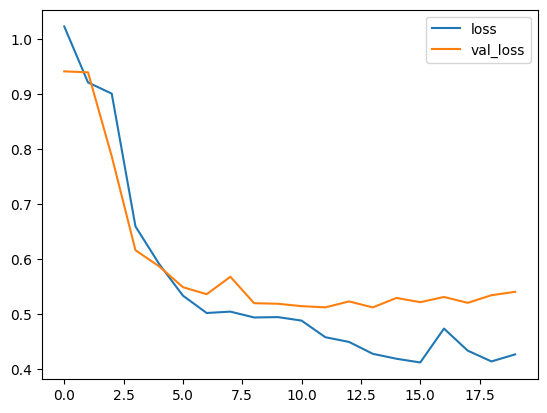

In [ ]:
plt.plot(transfer_model_history.history['loss'], label='loss')
plt.plot(transfer_model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
transfer_predicted = transfer_model.predict(ds_test_batched)

21/21 [==============================] - 15s 245ms/step


1/1 [==============================] - 0s 22ms/step


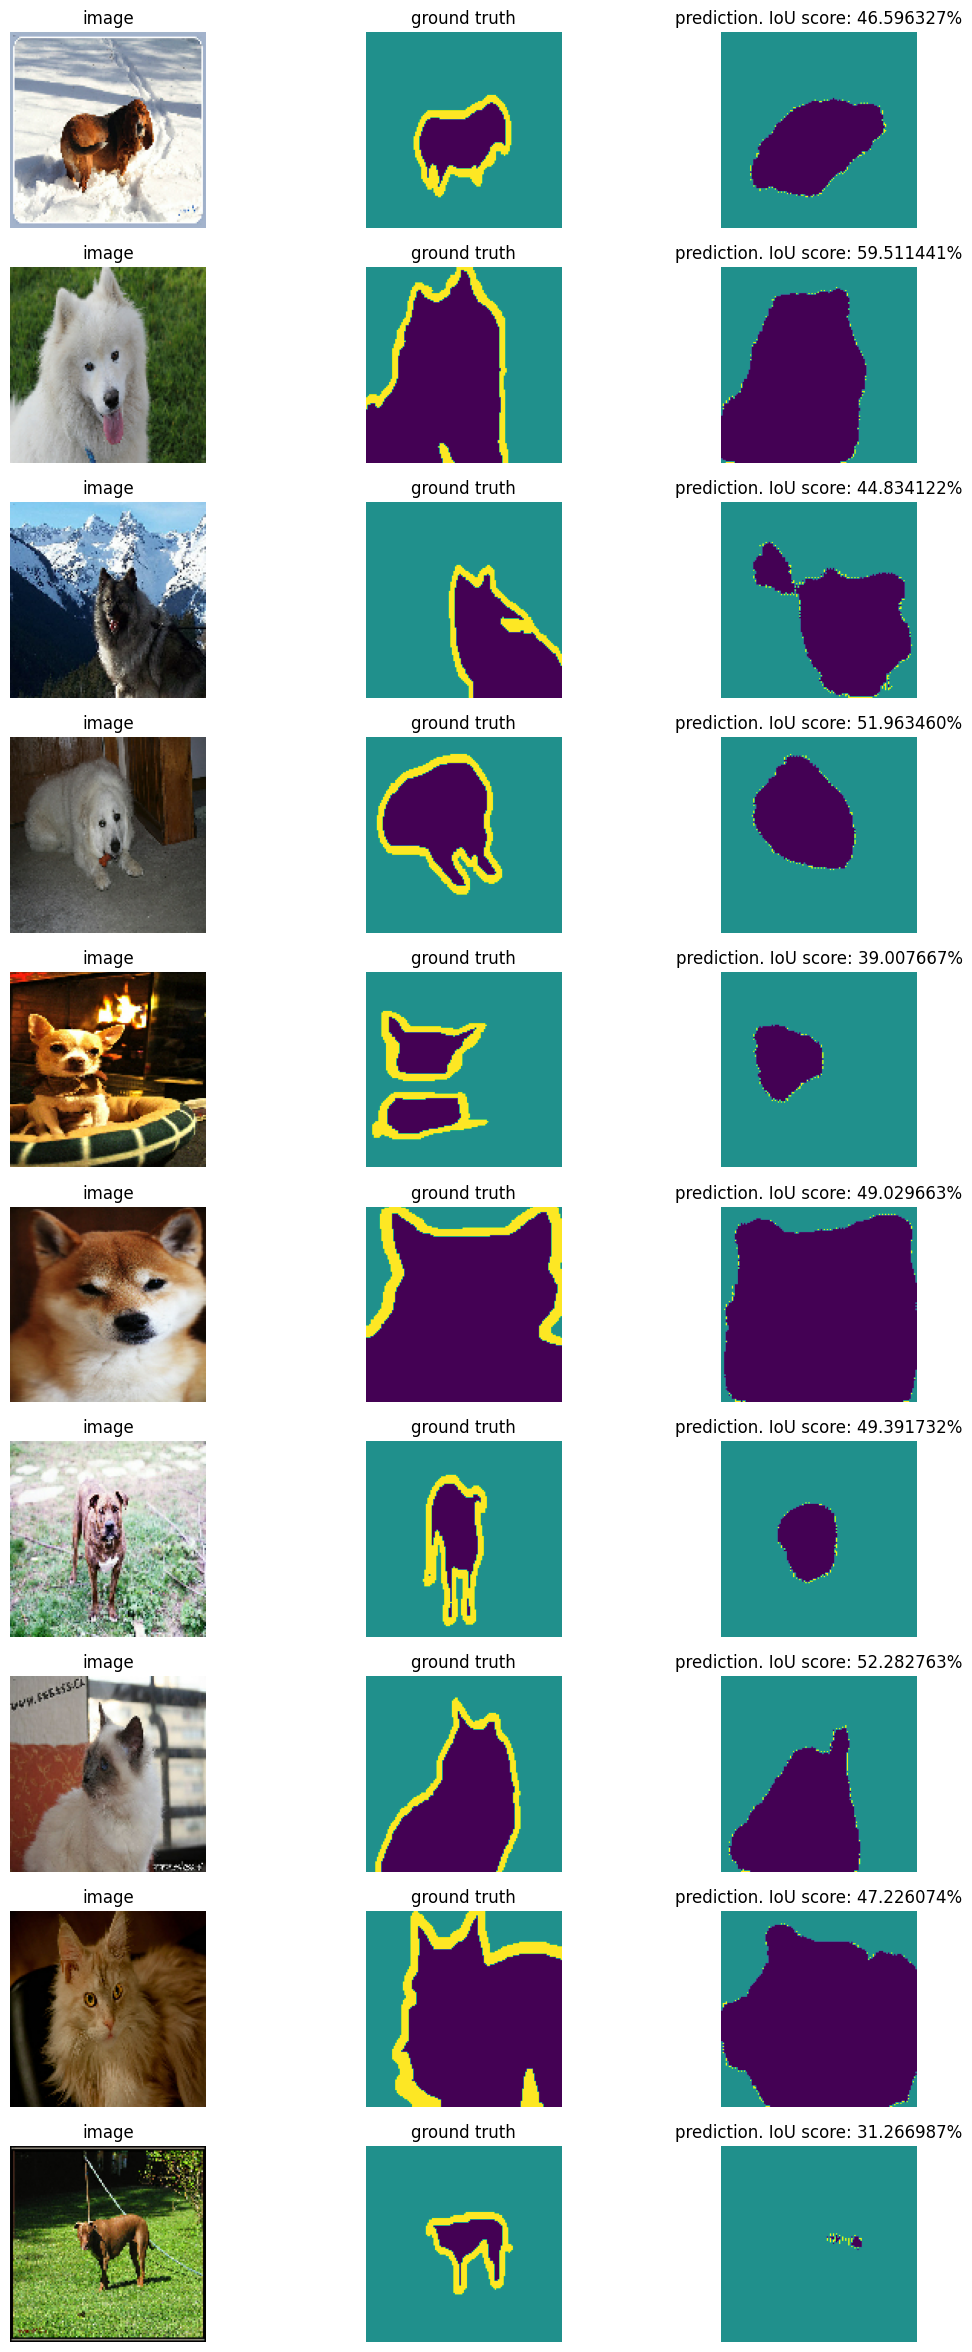

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(13, 30))

for i, (x, y) in enumerate(ds_test.skip(10).take(10)):
  y_pred = get_mask(transfer_model.predict(tf.expand_dims(x, axis=0)))
  score = keras.metrics.IoU(3, target_class_ids=list(range(3)))(y_pred, y)

  ax[i][0].axis('off')
  ax[i][1].axis('off')
  ax[i][2].axis('off')

  ax[i][0].set_title('image')
  ax[i][1].set_title('ground truth')
  ax[i][2].set_title(f'prediction. IoU score: {score:%}')

  ax[i][0].imshow(x)
  ax[i][1].imshow(y)
  ax[i][2].imshow(y_pred)

plt.show()

### Xception

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
)

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 63, 63, 32)           0         ['block1_conv1_bn[0][0]

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = base_model(inputs, training=False)

size = 4
while size < IMAGE_WIDTH:
  x = layers.Conv2DTranspose(16, 3, 2, padding="same")(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
  size *= 2

x = layers.Dense(3)(x)
transfer_model = keras.Model(inputs, x)

In [ ]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [ ]:
transfer_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 conv2d_transpose_25 (Conv2  (None, 8, 8, 16)          294928    
 DTranspose)                                                     
                                                                 
 dropout_10 (Dropout)        (None, 8, 8, 16)          0         
                                                                 
 conv2d_37 (Conv2D)          (None, 8, 8, 16)          2320      
                                                                 
 conv2d_transpose_26 (Conv2  (None, 16, 16, 16)        2320      
 DTranspose)                                               

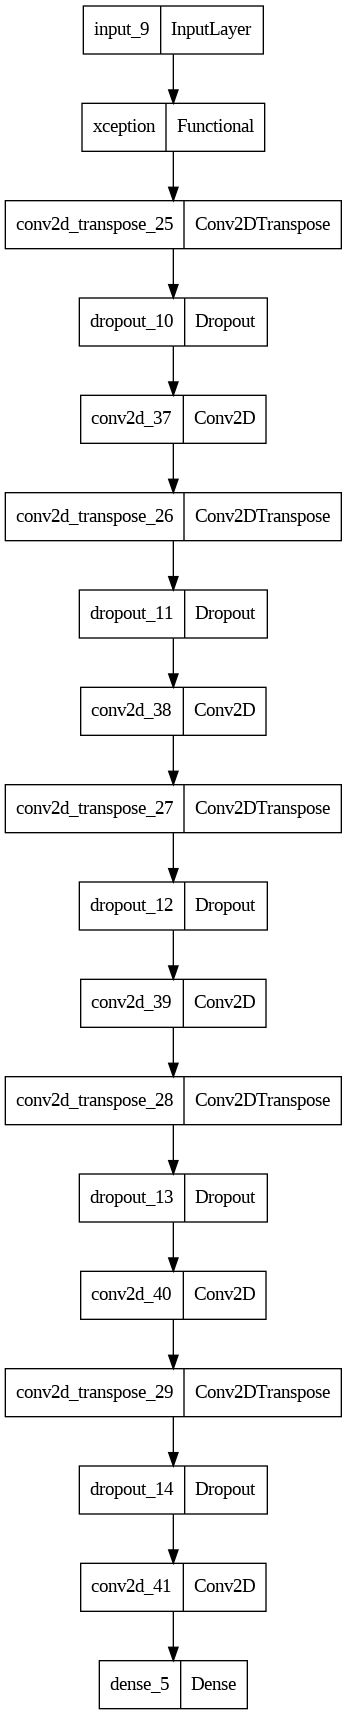

In [ ]:
utils.plot_model(transfer_model)

In [ ]:
epochs = 20

transfer_model_history = transfer_model.fit(
    ds_train_batched,
    epochs=epochs,
    steps_per_epoch=oxford_info.splits["train"].num_examples // batch_size,
    validation_steps=oxford_info.splits["test"].num_examples // batch_size // 5,
    validation_data=ds_val_batched
)

Epoch 1/20
115/115 [==============================] - 15s 102ms/step - loss: 1.0865 - accuracy: 0.5535 - val_loss: 0.9184 - val_accuracy: 0.5733
Epoch 2/20
115/115 [==============================] - 10s 90ms/step - loss: 0.8749 - accuracy: 0.5866 - val_loss: 0.8449 - val_accuracy: 0.5733
Epoch 3/20
115/115 [==============================] - 11s 97ms/step - loss: 0.8228 - accuracy: 0.5866 - val_loss: 0.8013 - val_accuracy: 0.5733
Epoch 4/20
115/115 [==============================] - 11s 97ms/step - loss: 0.7916 - accuracy: 0.5866 - val_loss: 0.7845 - val_accuracy: 0.5733
Epoch 5/20
115/115 [==============================] - 11s 94ms/step - loss: 0.7734 - accuracy: 0.5866 - val_loss: 0.7760 - val_accuracy: 0.5733
Epoch 6/20
115/115 [==============================] - 14s 118ms/step - loss: 0.7578 - accuracy: 0.5866 - val_loss: 0.7661 - val_accuracy: 0.5733
Epoch 7/20
115/115 [==============================] - 11s 99ms/step - loss: 0.7448 - accuracy: 0.5866 - val_loss: 0.7593 - val_accurac

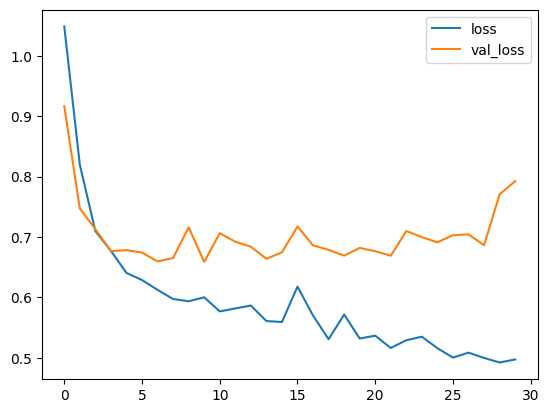

In [ ]:
plt.plot(transfer_model_history.history['loss'], label='loss')
plt.plot(transfer_model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


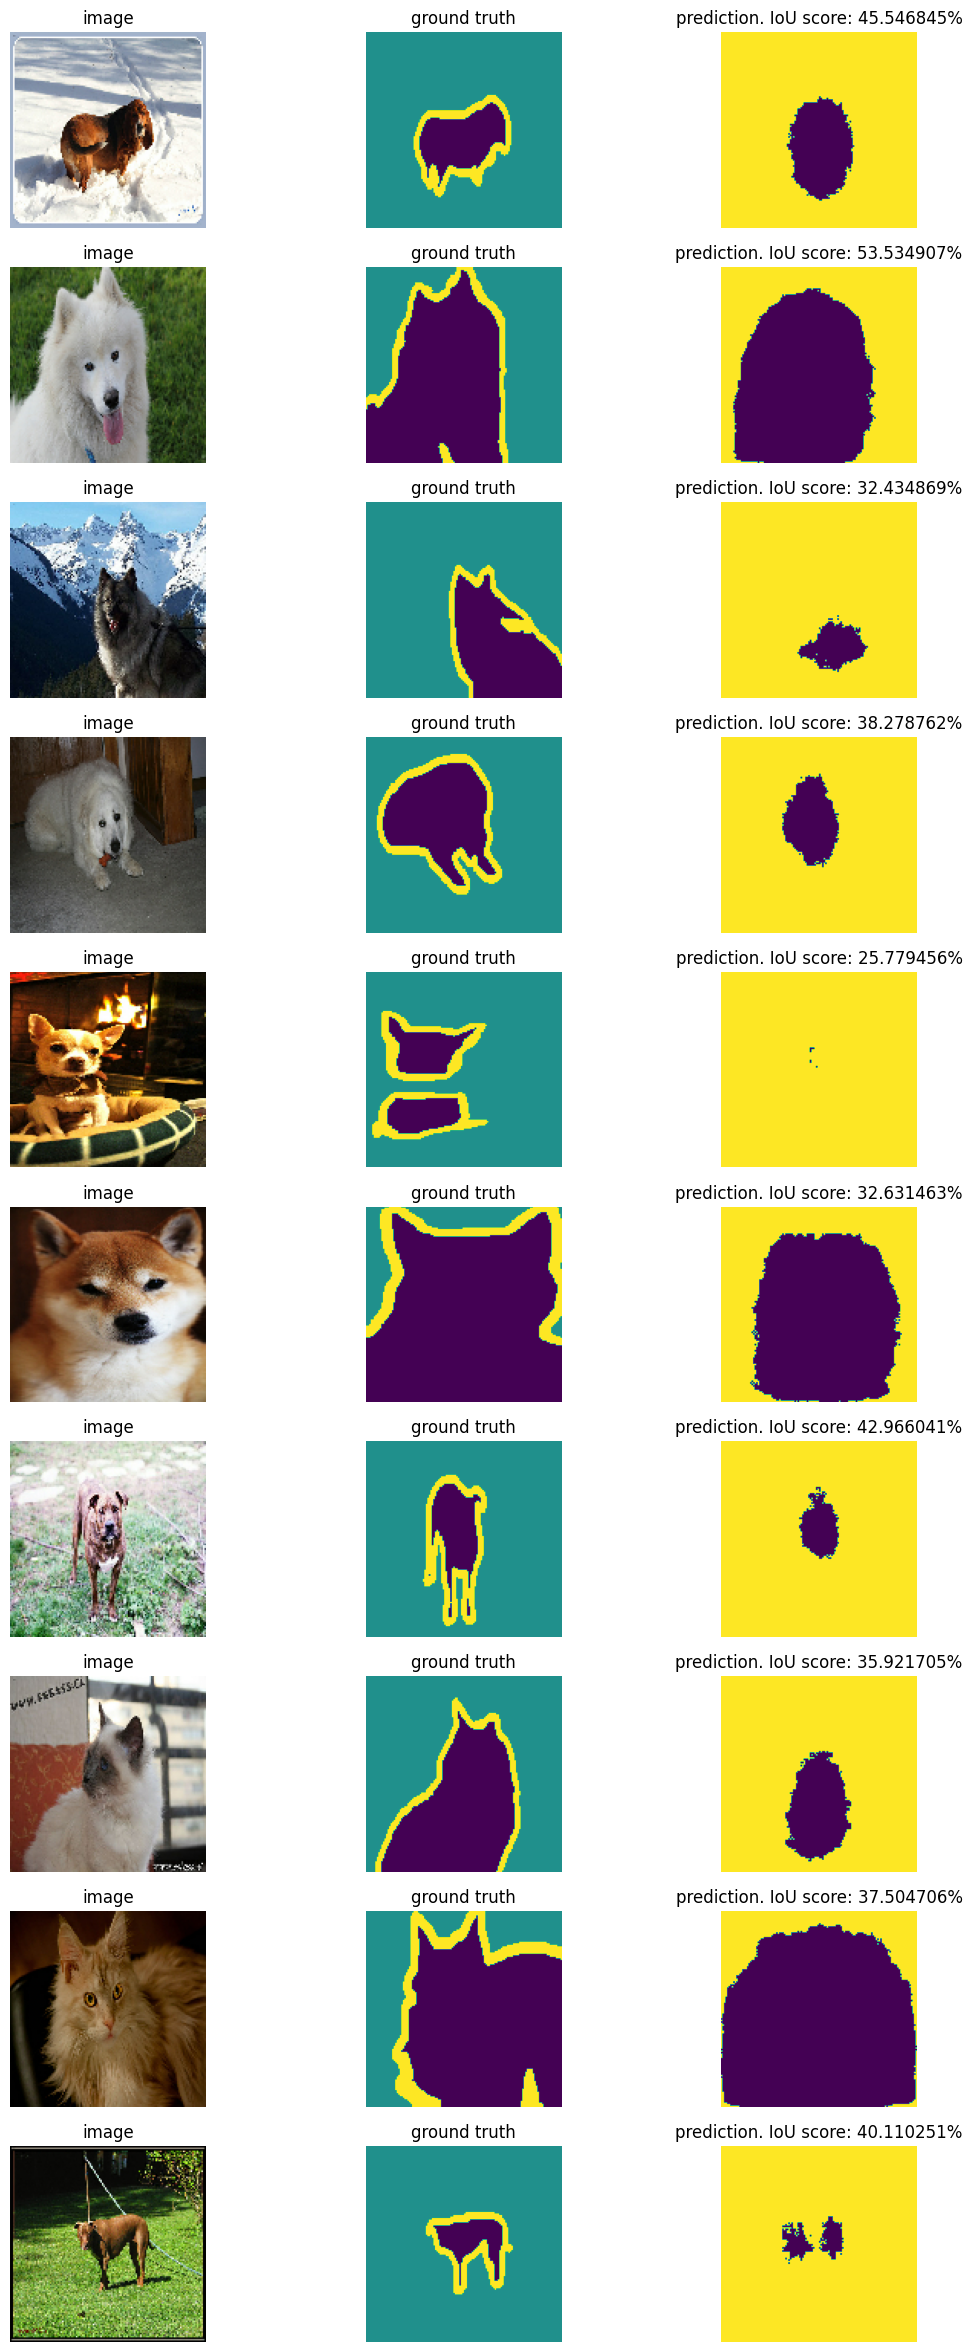

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(13, 30))

for i, (x, y) in enumerate(ds_test.skip(10).take(10)):
  y_pred = get_mask(transfer_model.predict(tf.expand_dims(x, axis=0)))
  score = keras.metrics.IoU(3, target_class_ids=list(range(3)))(y_pred, y)

  ax[i][0].axis('off')
  ax[i][1].axis('off')
  ax[i][2].axis('off')

  ax[i][0].set_title('image')
  ax[i][1].set_title('ground truth')
  ax[i][2].set_title(f'prediction. IoU score: {score:%}')

  ax[i][0].imshow(x)
  ax[i][1].imshow(y)
  ax[i][2].imshow(y_pred)

plt.show()

## Classic approach

In [ ]:
(image, result) = next(iter(ds_test.skip(11).take(1)))

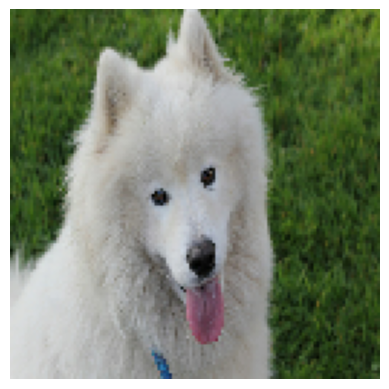

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
image_gray = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2GRAY)*255

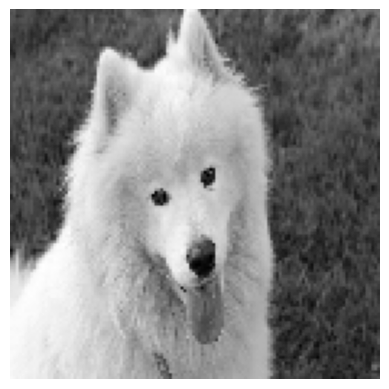

In [ ]:
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()

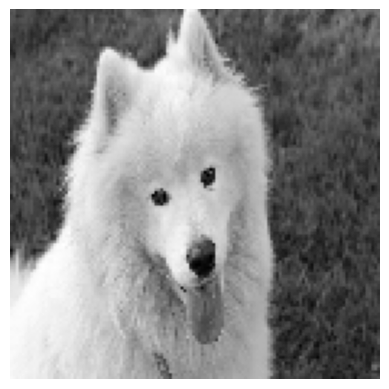

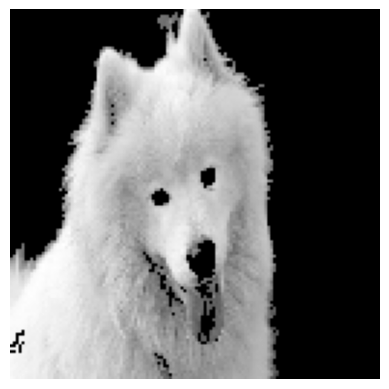

In [ ]:
def segmentation_classic(img, predicate, start_x, start_y):
    visited = np.zeros(img.shape, dtype=bool)
    segmented = np.zeros(img.shape)

    stack = [(start_x, start_y)]
    visited[start_x, start_y] = True
    segmented[start_x, start_y] = img[start_y, start_y]

    mv = 0
    ns = 0

    while stack:
        x, y = stack.pop()
        ns += 1
        mv = (mv*(ns-1)+img[x, y])/ns

        if 0 < x < img.shape[0] - 1 and 0 < y < img.shape[1] - 1:
            for neigh_x in range(x-1, x+2):
                for neigh_y in range(y-1, y+2):
                    if not visited[neigh_x, neigh_y] and predicate(img[neigh_x, neigh_y], mv):
                        segmented[neigh_x, neigh_y] = img[neigh_x, neigh_y]
                        stack.append((neigh_x, neigh_y))
                    visited[neigh_x, neigh_y] = True

    return segmented

segmented = segmentation_classic(img=image_gray, predicate=lambda x, y: abs(x-y) < 70, start_x=50, start_y=50)

plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
canny_lib_result = cv2.Canny(np.uint8(segmented), 120, 240, None, 3, 1)

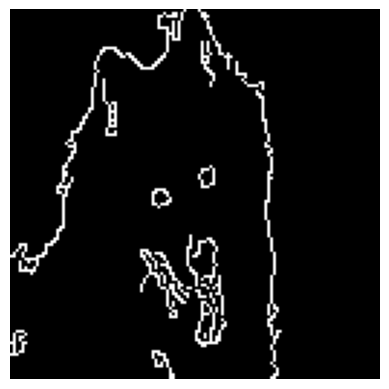

In [ ]:
plt.imshow(canny_lib_result, cmap='gray')
plt.axis('off')
plt.show()